##  Install and Import the Required Dependencies

In [ ]:
# Install all the required libraries

!pip install pdfplumber tiktoken openai chromaDB sentence-transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.9/266.9 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import all the required Dependencies

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Preprocess PDF files by Read, Process, and Chunking

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` enhances PDF parsing by extracting various elements beyond plain text, including tables, images, and more. Additionally, it provides extensive functionalities and visual debugging tools to assist in advanced preprocessing tasks.

In [ ]:
# Define the path of the given PDF file
single_pdf_path = '/content/drive/MyDrive/Colab Notebooks/Principal-Sample-Life-Insurance-Policy.pdf'


#### Reading a single PDF file and exploring it through pdfplumber

In [ ]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    one_page = pdf.pages[4]

    # Extract text from the first page
    text = one_page.extract_text()

    # Extract tables from the first page
    tables = one_page.extract_tables()

    # Print the extracted text
    print(text)

PRINCIPAL LIFE INSURANCE COMPANY
(called The Principal in this Group Policy)
Des Moines, Iowa 50392-0002
This group insurance policy is issued to:
RHODE ISLAND JOHN DOE
(called the Policyholder in this Group Policy)
The Date of Issue is November 1, 2007.
In return for the Policyholder's application and payment of all premiums when due, The Principal
agrees to provide:
MEMBER LIFE INSURANCE
MEMBER ACCIDENTAL DEATH AND DISMEMBERMENT INSURANCE
DEPENDENT LIFE INSURANCE
subject to the terms and conditions described in this Group Policy.
GROUP POLICY NO. GL S655
RENEWABLE TERM - NON-PARTICIPATING
CONTRACT STATE OF ISSUE: RHODE ISLAND
This policy has been updated effective January 1, 2014
GC 6000 TITLE PAGE


In [ ]:
# View the table in the page, if any
if len(tables) > 0:
  tables[0]
else:
  print("No tables found")

No tables found


#### Extracting text from multiple PDFs

Now, let's attempt to read multiple documents, extract text from them with suitable preprocessing, and then store the extracted text in a dataframe.

In [ ]:
# Define the path where all pdf documents are present

pdf_path = "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [ ]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [ ]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("Principal-Sample-Life-Insurance-Policy.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
All PDFs have been processed.


In [ ]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf
1,Page 2,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf
3,Page 4,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,Principal-Sample-Life-Insurance-Policy.pdf
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,Principal-Sample-Life-Insurance-Policy.pdf
61,Page 62,A claimant may request an appeal of a claim de...,Principal-Sample-Life-Insurance-Policy.pdf
62,Page 63,This page left blank intentionally,Principal-Sample-Life-Insurance-Policy.pdf


In [ ]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[0]

'DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014'

In [ ]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [ ]:
insurance_pdfs_data['Text_Length']

0      30
1       5
2     230
3       5
4     110
     ... 
59    285
60    418
61    322
62      5
63      8
Name: Text_Length, Length: 64, dtype: int64

In [ ]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352


In [ ]:
# Store the metadata for each page in a separate column

metadata = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data['Metadata'] = metadata


#insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

#insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

<ipython-input-24-dd0c33699af1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = metadata


In [ ]:
#insurance_pdfs_data.drop(['Metadata'],inplace=True,axis=1)
insurance_pdfs_data.head()

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...


In [ ]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,Principal-Sample-Life-Insurance-Policy.pdf,30,{'Policy_Name': 'Principal-Sample-Life-Insuran...
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,Principal-Sample-Life-Insurance-Policy.pdf,230,{'Policy_Name': 'Principal-Sample-Life-Insuran...
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,Principal-Sample-Life-Insurance-Policy.pdf,110,{'Policy_Name': 'Principal-Sample-Life-Insuran...
5,Page 6,TABLE OF CONTENTS PART I - DEFINITIONS PART II...,Principal-Sample-Life-Insurance-Policy.pdf,153,{'Policy_Name': 'Principal-Sample-Life-Insuran...
6,Page 7,Section A – Eligibility Member Life Insurance ...,Principal-Sample-Life-Insurance-Policy.pdf,176,{'Policy_Name': 'Principal-Sample-Life-Insuran...
7,Page 8,Section A - Member Life Insurance Schedule of ...,Principal-Sample-Life-Insurance-Policy.pdf,171,{'Policy_Name': 'Principal-Sample-Life-Insuran...
8,Page 9,P ART I - DEFINITIONS When used in this Group ...,Principal-Sample-Life-Insurance-Policy.pdf,387,{'Policy_Name': 'Principal-Sample-Life-Insuran...
9,Page 10,T he legally recognized union of two eligible ...,Principal-Sample-Life-Insurance-Policy.pdf,251,{'Policy_Name': 'Principal-Sample-Life-Insuran...
10,Page 11,(2) has been placed with the Member or spouse ...,Principal-Sample-Life-Insurance-Policy.pdf,299,{'Policy_Name': 'Principal-Sample-Life-Insuran...
11,Page 12,An institution that is licensed as a Hospital ...,Principal-Sample-Life-Insurance-Policy.pdf,352,{'Policy_Name': 'Principal-Sample-Life-Insuran...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [ ]:
# Set the API key
filepath = "/content/drive/MyDrive/Colab Notebooks/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

#openai.api_key

In [ ]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [ ]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/Colab Notebooks/ChromaDB_Data'

In [ ]:
import chromadb

In [ ]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [ ]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=openai.api_key, model_name=model)

In [ ]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [ ]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [ ]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [ ]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': [[-0.022495761513710022,
   0.01878996379673481,
   -0.027245447039604187,
   -0.03126441314816475,
   -0.0036797013599425554,
   0.02787178009748459,
   0.0008306240779347718,
   0.023630989715456963,
   -0.016623899340629578,
   0.004332130774855614,
   -0.005252055823802948,
   0.004087469540536404,
   -0.006282893940806389,
   0.0233047753572464,
   -0.011234832927584648,
   0.031081732362508774,
   0.0029016793705523014,
   -0.02470097318291664,
   0.030716370791196823,
   0.007822627201676369,
   0.006439477205276489,
   0.018933497369289398,
   0.009649429470300674,
   0.012520118616521358,
   -0.012467923574149609,
   -0.009453700855374336,
   0.017889611423015594,
   -0.021699799224734306,
   0.023604892194271088,
   0.0030386894941329956,
   0.013303033076226711,
   -0.014588318765163422,
   -0.03358706086874008,
   -0.041103046387434006,
   -0.008481580764055252,
   0.013635772280395031,
   -0.0025461053010076284,
   -0.003901527263224

In [ ]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [ ]:
cache_collection.peek()

{'ids': [],
 'embeddings': [],
 'metadatas': [],
 'documents': [],
 'uris': None,
 'data': None}

## Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [84]:
# Read the user query

query = input()

Is this a good insurance plan?


In [85]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [86]:
cache_results

{'ids': [['Does this policy cover pre-existing conditions? If so, are there any limitations?']],
 'distances': [[0.2825396185130707]],
 'metadatas': [[{'distances0': '0.3556974081675591',
    'distances1': '0.3617181330252942',
    'distances2': '0.38019086798436214',
    'distances3': '0.3854873985104963',
    'distances4': '0.3860015133383785',
    'distances5': '0.3881200011424705',
    'distances6': '0.3885213173975777',
    'distances7': '0.3907669691199378',
    'distances8': '0.3933487400352778',
    'distances9': '0.3967175888966099',
    'documents0': "a . A licensed Doctor of Medicine (M.D.) or Osteopathy (D.O.); or b. any other licensed health care practitioner that state law requires be recognized as a Physician under this Group Policy. The term Physician does not include the Member, an employee of the Member, a business or professional partner or associate of the Member, any person who has a financial affiliation or business interest with the Member, anyone related to the 

In [87]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [88]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(10):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Not found in cache. Found in main collection.


In [89]:
results_df

,Metadatas,Documents,Distances,IDs
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.399983,14
1,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,0.412997,1
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.414612,10
3,"{'Page_No.': 'Page 46', 'Policy_Name': 'Princi...",PART IV - BENEFITS Section A - Member Life Ins...,0.417876,43
4,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",Exposure Exposure to the elements will be pres...,0.419986,52
5,"{'Page_No.': 'Page 5', 'Policy_Name': 'Princip...",PRINCIPAL LIFE INSURANCE COMPANY (called The P...,0.421049,2
6,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",Section C - Dependent Life Insurance Article 1...,0.425636,56
7,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi...",Section B - Member Accidental Death and Dismem...,0.426286,50
8,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Section F - Individual Purchase Rights Article...,0.427481,39
9,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,0.429671,15


## Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

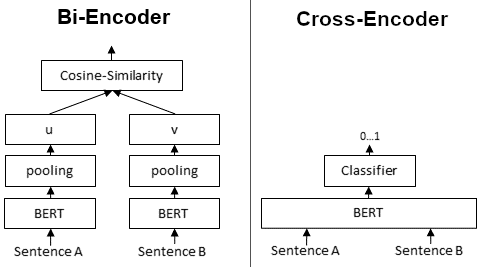

<br>

In [90]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [91]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [92]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [93]:
scores

array([  3.8467627, -11.252879 ], dtype=float32)

In [94]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [95]:
cross_rerank_scores

array([ -7.2541194,  -8.482487 , -10.187284 ,  -6.5392156,  -9.255538 ,
        -9.329864 ,  -6.518543 ,  -6.2758894,  -4.837692 ,  -9.028221 ],
      dtype=float32)

In [96]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [97]:
results_df

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.399983,14,-7.254119
1,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,0.412997,1,-8.482487
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.414612,10,-10.187284
3,"{'Page_No.': 'Page 46', 'Policy_Name': 'Princi...",PART IV - BENEFITS Section A - Member Life Ins...,0.417876,43,-6.539216
4,"{'Page_No.': 'Page 55', 'Policy_Name': 'Princi...",Exposure Exposure to the elements will be pres...,0.419986,52,-9.255538
5,"{'Page_No.': 'Page 5', 'Policy_Name': 'Princip...",PRINCIPAL LIFE INSURANCE COMPANY (called The P...,0.421049,2,-9.329864
6,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",Section C - Dependent Life Insurance Article 1...,0.425636,56,-6.518543
7,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi...",Section B - Member Accidental Death and Dismem...,0.426286,50,-6.275889
8,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Section F - Individual Purchase Rights Article...,0.427481,39,-4.837692
9,"{'Page_No.': 'Page 18', 'Policy_Name': 'Princi...",c . a copy of the form which contains the stat...,0.429671,15,-9.028221


In [98]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
0,"{'Page_No.': 'Page 17', 'Policy_Name': 'Princi...",a. be actively engaged in business for profit ...,0.399983,14,-7.254119
1,"{'Page_No.': 'Page 3', 'Policy_Name': 'Princip...",POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,0.412997,1,-8.482487
2,"{'Page_No.': 'Page 13', 'Policy_Name': 'Princi...",a . A licensed Doctor of Medicine (M.D.) or Os...,0.414612,10,-10.187284


In [99]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,Metadatas,Documents,Distances,IDs,Reranked_scores
8,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi...",Section F - Individual Purchase Rights Article...,0.427481,39,-4.837692
7,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi...",Section B - Member Accidental Death and Dismem...,0.426286,50,-6.275889
6,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi...",Section C - Dependent Life Insurance Article 1...,0.425636,56,-6.518543


In [100]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [101]:
top_3_RAG

,Documents,Metadatas
8,Section F - Individual Purchase Rights Article...,"{'Page_No.': 'Page 42', 'Policy_Name': 'Princi..."
7,Section B - Member Accidental Death and Dismem...,"{'Page_No.': 'Page 53', 'Policy_Name': 'Princi..."
6,Section C - Dependent Life Insurance Article 1...,"{'Page_No.': 'Page 59', 'Policy_Name': 'Princi..."


##  Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [102]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [103]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [104]:
# Print the response

print("\n".join(response))

Based on the information available in the insurance documents, I will need to review the specifics of the insurance plan to determine if it is good. Please provide the policy name or any specific features you are looking for in order to give a more accurate assessment.

---

Citations:
1. Policy Name: Principal Insurance Policy
   Page Number: Page 42

2. Policy Name: Principal Insurance Policy
   Page Number: Page 53

3. Policy Name: Principal Insurance Policy
   Page Number: Page 59
